In [1]:
import pandas as pd
import numpy as np

import re

import nltk
import re
#import gensim
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize

from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

from scipy import spatial

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

from sklearn.metrics import accuracy_score,precision_recall_curve, precision_score, recall_score, f1_score,confusion_matrix, classification_report, roc_auc_score


import pymorphy2

%matplotlib inline
pd.options.display.max_colwidth = 200

### dataset - customer reviews about the company after a purchase
#### columns:
*comment* - customer reviews

*rating* - company rating
*senti* - 0 - rating 1-3, 1 - rating 4-5

In [5]:
df = pd.read_csv('data/company_opinions_rus.csv', sep=';')

In [7]:
len(df)

8366

In [8]:
df.head()

,comment,rating,senti,lang
0,"Заказал, перезвонили, согласовали, отослали, получил, доволен, спасибо.",5,1,ru
1,Ребята-молодцы!!!Перезвонили в течении 20 минут;отправили посылку в течении часа.Дочке 7 лет-она в восторге)Это был ей подарок на день рождения...Научилась кататься за 5 минут(и это первый раз)-са...,5,1,ru
2,НЕ покупай эту дрочь. \nКупил тут павер банк на 45000 mAh \nТелефон не заряжает вообще \nЭлектронную сигарету заряжает раза 4-6 и все павер банк сдох даже не включается\nПозвонил на сайт по номеру...,1,0,ru
3,"Обслуживание супер! Заказ доставили на следующий день, все понравилось, цена актуальна, все на высшем уровне. Советую всем покупать товары у этой компании. Благодарю вас, буду покупать только тут.",5,1,ru
4,"Очень довольна работой магазина, в 10.00 заказ приняли, в 12 уже пришла транспортная накладная.",5,1,ru


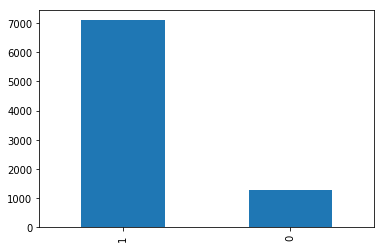

In [9]:
df["senti"].value_counts().plot.bar()

## Text preprocessing

In [10]:
# russian stop words
morph = pymorphy2.MorphAnalyzer()

ru_ukr_stop_words = get_stop_words('russian')

In [11]:
def clean_text(text):
    text = re.sub(r'[^а-яa-zІіЇїҐґ ]', ' ', text.lower())
    # lemmatization and remove stop words
    text = ' '.join([morph.parse(word)[0].normal_form for word in text.split() if word not in ru_ukr_stop_words])
    return text

In [12]:
def text_prepare(df):
    df.comment = df.comment.apply(lambda x: clean_text(x))
    return df

In [14]:
df_prepar = text_prepare(df.copy(deep=True))

## Build Word2Vec Model with Gensim

In [15]:
# create corpus for model
corpus = [document.split() for document in df_prepar.comment.tolist()]

In [16]:
# Importing the built-in logging module
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [17]:
# Set values for various parameters
size = 100    # Word vector dimensionality  
window = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count  
num_workers = 4     # Number of parallel threads
sample = 1e-3   # (0.001) Downsample setting for frequent words 

from gensim.models import word2vec
w2v_model = word2vec.Word2Vec(corpus,
                              workers=num_workers,
                              size=size,
                              window=window,
                              min_count=min_word_count, 
                              sample=sample, 
                              iter=50)

2018-09-18 13:42:46,127 : INFO : 'pattern' package not found; tag filters are not available for English
2018-09-18 13:42:46,132 : INFO : collecting all words and their counts
2018-09-18 13:42:46,133 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-09-18 13:42:46,170 : INFO : collected 9277 word types from a corpus of 92864 raw words and 8366 sentences
2018-09-18 13:42:46,171 : INFO : Loading a fresh vocabulary
2018-09-18 13:42:46,200 : INFO : effective_min_count=1 retains 9277 unique words (100% of original 9277, drops 0)
2018-09-18 13:42:46,202 : INFO : effective_min_count=1 leaves 92864 word corpus (100% of original 92864, drops 0)
2018-09-18 13:42:46,239 : INFO : deleting the raw counts dictionary of 9277 items
2018-09-18 13:42:46,245 : INFO : sample=0.001 downsamples 58 most-common words
2018-09-18 13:42:46,248 : INFO : downsampling leaves estimated 74393 word corpus (80.1% of prior 92864)
2018-09-18 13:42:46,281 : INFO : estimated required memory for

2018-09-18 13:42:48,419 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-18 13:42:48,429 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-18 13:42:48,435 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-18 13:42:48,447 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-18 13:42:48,449 : INFO : EPOCH - 15 : training on 92864 raw words (74413 effective words) took 0.1s, 553482 effective words/s
2018-09-18 13:42:48,587 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-18 13:42:48,593 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-18 13:42:48,595 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-18 13:42:48,606 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-18 13:42:48,607 : INFO : EPOCH - 16 : training on 92864 raw words (74359 effective words) took 0.1s, 520590 effective words/s
2018

2018-09-18 13:42:50,543 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-18 13:42:50,548 : INFO : EPOCH - 31 : training on 92864 raw words (74475 effective words) took 0.1s, 588263 effective words/s
2018-09-18 13:42:50,677 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-18 13:42:50,690 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-18 13:42:50,699 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-18 13:42:50,707 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-18 13:42:50,709 : INFO : EPOCH - 32 : training on 92864 raw words (74285 effective words) took 0.1s, 513445 effective words/s
2018-09-18 13:42:50,808 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-18 13:42:50,812 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-18 13:42:50,814 : INFO : worker thread finished; awaiting finish of 1 more threads
2018

2018-09-18 13:42:52,236 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-18 13:42:52,245 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-18 13:42:52,254 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-18 13:42:52,260 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-18 13:42:52,261 : INFO : EPOCH - 48 : training on 92864 raw words (74642 effective words) took 0.1s, 641914 effective words/s
2018-09-18 13:42:52,387 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-18 13:42:52,397 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-18 13:42:52,404 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-18 13:42:52,408 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-18 13:42:52,409 : INFO : EPOCH - 49 : training on 92864 raw words (74573 effective words) took 0.1s, 535838 effective words/s
2018

In [22]:
# This will print the most similar words present in the model
w2v_model.wv.most_similar("прислать")

/home/l.poberezhnya/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('выслать', 0.6147624850273132),
 ('прийти', 0.6103254556655884),
 ('наушник', 0.5874800086021423),
 ('пришлый', 0.5606255531311035),
 ('положить', 0.5380216836929321),
 ('dualshock', 0.5303895473480225),
 ('присылать', 0.529650092124939),
 ('мусорный', 0.5145374536514282),
 ('шина', 0.5089768171310425),
 ('отослать', 0.5086157917976379)]

In [23]:
w2v_model.n_similarity(['товар', 'покупать'], ['хороший', 'товар'])

/home/l.poberezhnya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  """Entry point for launching an IPython kernel.
/home/l.poberezhnya/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.5683244

## Visualize word embeddings

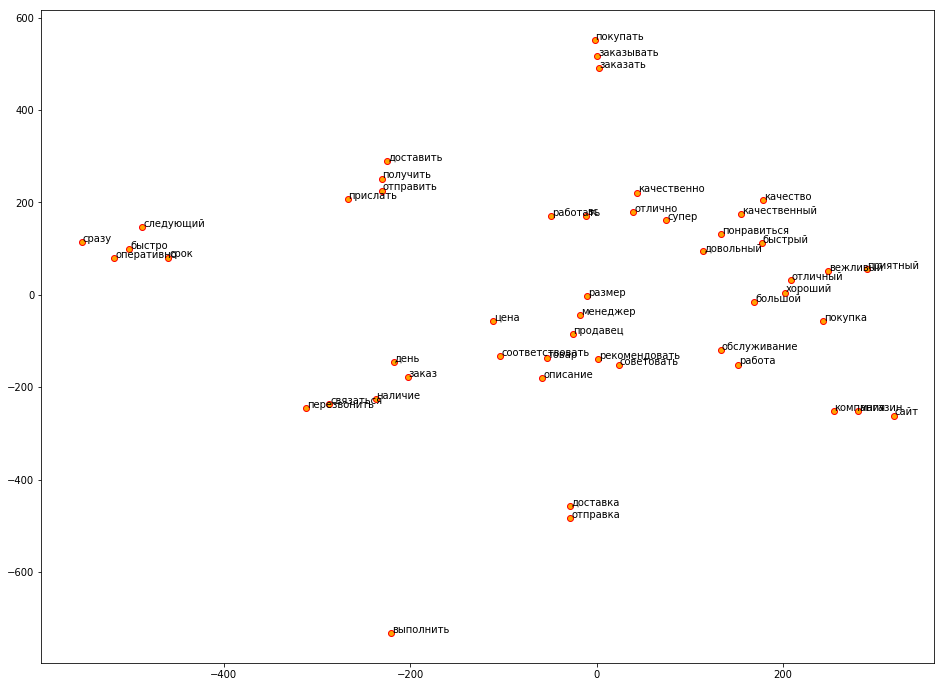

In [24]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word[:50]
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 12))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Build framework for getting document level embeddings

In [25]:
# Function to average all word vectors in a paragraph
def average_word_vectors(words, model, vocabulary, num_features):
    # Pre-initialising empty numpy array for speed
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

In [26]:
# Function for calculating the average feature vector
def averaged_word_vectorizer(corpus, model, num_features):
     #Converting Index2Word which is a list to a set for better speed in the execution.
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [27]:
w2v_feature_array = averaged_word_vectorizer(corpus= corpus, model=w2v_model,
                                             num_features=size)
pd.DataFrame(w2v_feature_array).head(5)

/home/l.poberezhnya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.348616,0.621150,-1.118575,0.944733,-0.278085,0.148535,-0.364424,-0.279599,0.247831,0.538966,...,-1.075180,0.662823,0.542219,-1.268371,-0.126761,-0.026742,0.244501,0.099595,-0.175076,-0.285059
1,-0.257120,-0.156997,-0.385726,0.989836,-0.327430,-0.039469,0.126848,-0.553668,0.581213,0.237885,...,-0.845938,0.815230,-0.426227,-0.516294,0.070514,0.112569,0.753882,-0.306606,0.316122,-0.640264
2,-0.198504,0.490291,-0.316017,0.424619,-0.503569,-0.116832,-0.524306,-0.410460,-0.606865,0.373758,...,-0.406558,-0.072686,-0.034890,-0.455392,-0.227338,0.589009,-0.055486,-0.067105,0.416513,0.237187
3,-0.682196,-0.482461,-0.365490,0.427516,-0.981684,0.671163,0.207683,-0.867986,1.140346,0.311901,...,-0.106703,0.120396,0.508741,-0.097148,-0.590097,0.570348,0.566995,0.269596,-0.963637,-1.167268
4,0.335301,0.179306,-0.599662,1.068209,-0.225501,-0.049345,0.974276,-0.739775,1.098363,0.477037,...,-0.295809,0.328723,-0.206310,-0.281353,-0.444349,0.475688,0.372802,-0.075923,-0.534736,0.166552


### Support Vector Machines

In [29]:
X = w2v_feature_array
y = df_prepar['senti']

In [30]:
# use stratify for unbalanced dataset 
random_state=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=random_state)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5856, 100), (2510, 100), (5856,), (2510,))

In [32]:
clf = svm.SVC()
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
predict_svm_clf = svm_clf.predict(X_test)
report_svm_clf = classification_report(y_test, predict_svm_clf, target_names=['0', '1'])
print('roc_auc: {0:.2f}'.format(roc_auc_score(y_test, predict_svm_clf)))
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, predict_svm_clf)))
print(report_svm_clf)

roc_auc: 0.87
Accuracy: 0.95
             precision    recall  f1-score   support

          0       0.88      0.76      0.82       381
          1       0.96      0.98      0.97      2129

avg / total       0.95      0.95      0.95      2510

